# Logistic Regression

Logistic Regression is a simple classification technique that analyzes the relationship between a quantitative variable x and a dichotomous categorical variable y. Similar to linear regression, this relationship is inferred by applying a linear transformation to the data

$$
Y = Xw
$$

# Binary-Cross-Entropy

However, Logistic Regression is unique in the way that it **learns relationships.** Given that we have to classify y given x, a natural choice of performance/criterion is the Binary Cross Entropy Loss.

In short, Cross Entropy is a popular choice of option to judge classification task models whose output is a probability mass function. It is computed by independently applying below function to each prediction

$$
L(\hat{y},y)=y\cdot -log(\hat{y})^T
$$

And its binary re-formulation

$$
L(\hat{y},y)=y\cdot-log(\hat{y})+(1-y)\cdot(-log(1-\hat{y}))
$$


In general, Cross-Entropy loss exponentially increases as our predictions diverge from the truth; conversely, as our predictions become infinitely close to our target, the loss equates to zero. 

Below graph models Binary-Cross-Entropy when target is either 1 or 0 at different levels of prediction

<img src="C:\Users\erick\Documents\University\UH-D\Spring 2020\ML\git_repo\DL-with-PyTorch\img\BCE.png" alt="image-20200508081156737" style="zoom:75%;" />



We can derive the gradient of our Loss function w.r.t. our prediction for the backward pass by using some simple Calculus

$$
\begin{split}\frac{\partial L(\hat{y},y)}{\partial \hat{y}} & =\frac{\partial}{\hat{y}}(y\cdot-log(\hat{y})) + \frac{\partial}{\hat{y}}(1-y)\cdot(-log(1-\hat{y})) \\& =\frac{-y}{\hat{y}} - (\frac{1-y}{1-\hat{y}}* -1) \\& = \frac{-y}{\hat{y}} + \frac{1-y}{1-\hat{y}}\end{split}
$$

Given that the Loss function is usually the last forward operation, it also becomes the first gradient we need to compute for the backward pass. For this reason, there is no incoming gradient that we need to worry about integrating.

However, instead of calculating a backward pass of *each prediction* w.r.t. our weight parameters, we usually take the mean prediction confidence as a way to better gauge our model's performance.  

In this case, we will be calculating below gradients

$$
\frac{\partial }{\partial \hat{w}}avg(L(\hat{y},y))
$$


Once our loss has been  computed, we follow the general DL procedure of taking a "step" towards steepest descent by computing the gradient of our Loss/criterion function w.r.t. weight parameters

$$
w_j=w_j-\alpha\frac{\partial }{\partial w_j}L(w_j)
$$

# Sigmoid

In order for us to use the Binary-Cross-Entropy as our criterion, we must first ensure that our model's output ranges between ```[0,1]```. Of coarse, once rounded, this ensures our binary prediction:

* 1 = Yes
* 0 = No

We will do this by applying a ```Sigmoid``` layer before feeding our inputs to the Loss function.

A sigmoid layers is an activation function that "squeezes" all our inputs to a range between ```[0,1]``` by applying below function

$$
\sigma(y)=\frac{1}{1+e^{-y}}
$$

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/8/88/Logistic-curve.svg/1200px-Logistic-curve.svg.png" alt="Sigmoid function - Wikipedia" style="zoom:40%;" />

One distinct property of the Sigmoid function is that its derivative can be calculated by a simple re-formulation of its forward operation

$$
\frac{\partial \sigma}{\partial y} = \sigma(y)(1-\sigma(y))
$$


Given that activation function is applied independently to each element, its derivative function will be equivalent for all inputs.

$$
\sigma(y) = \sigma\begin{pmatrix}y_1 & y_2 &y_3\end{pmatrix} = \begin{pmatrix}\sigma(y_1) & \sigma(y_2) & \sigma(y_3)\end{pmatrix} \\\frac{\partial \sigma}{\partial y} = \begin{pmatrix}\sigma(y_1)(1-\sigma(y_1) & \sigma(y_2)(1-\sigma(y_2) &\sigma(y_3)(1-\sigma(y_3)\end{pmatrix}
$$

Further, given that Sigmoid introduces no new parameters, its backward pass classifies as an intermediate operation. As a result, we can integrate the latest incoming gradient of the chain rule ($\frac{\partial L}{\partial \sigma}$) with the partial of our sigmoid function ($\frac{\partial \sigma}{\partial y}$) by a simple Hadamard product

$$
\frac{\partial L}{\partial y}=\frac{\partial L}{\partial \sigma}\odot \frac{\partial \sigma}{\partial y}
$$

**NOTE:** if the above statements do not make much sense, make sure to review the [Linear Layer]() and/or [ReLU]() tutorial where I expand on such concepts

# Build Logistic Regression

Now that we have defined all our needed methods, we will now manually implement the forward/backward pass of each operation using PyTorch's capabilities.

**NOTE:** We will not go in-depth on our Linear Layer implementation as this was done on this [tutorial](Linear Layer.ipynb)


In [220]:
import torch
torch.randn((2,2)).cuda()
import torch.nn as nn

In [221]:
####################### Linear Layer ###################


class Linear_Layer(torch.autograd.Function):
    """
    Define a Linear Layer operation
    """
    @staticmethod
    def forward(ctx, input,weights, bias = None):
        """
        In the forward pass, we feed this class all necessary objects to 
        compute a  linear layer (input, weights, and bias)
        """
        # input.dim = (B, in_dim)
        # weights.dim = (in_dim, out_dim)
        
        # given that the grad(output) wrt weight parameters equals the input,
        # we will save it to use for backpropagation
        ctx.save_for_backward(input, weights, bias)
        
        
        # linear transformation
        # (B, out_dim) = (B, in_dim) * (in_dim, out_dim)
        output = torch.mm(input, weights)
        
        if bias is not None:
            # bias.shape = (out_dim)
            
            # expanded_bias.shape = (B, out_dim), repeats bias B times
            expanded_bias = bias.unsqueeze(0).expand_as(output)
            
            # element-wise addition
            output += expanded_bias
        
        return output

    
    @staticmethod
    def backward(ctx, incoming_grad):
        """
        In the backward pass we receive a Tensor (output_grad) containing the 
        gradient of the loss with respect to our f(x) output, 
        and we now need to compute the gradient of the loss
        with respect to our defined function.
        """
        # incoming_grad.shape = (B, out_dim)
        
        # extract inputs from forward pass
        input, weights, bias = ctx.saved_tensors 
        
        # assume none of the inputs need gradients
        grad_input = grad_weight = grad_bias = None
        
        
        # if input requires grad
        if ctx.needs_input_grad[0]:
            # (B, in_dim) = (B, out_dim) * (out_dim, in_dim)
            grad_input = incoming_grad.mm(weights.t())
            
        # if weights require grad
        if ctx.needs_input_grad[1]:
            # (out_dim, in_dim) = (out_dim, B) * (B, in_dim) 
            grad_weight = incoming_grad.t().mm(input)
            
        # if bias requires grad
        if bias is not None and ctx.needs_input_grad[2]:
            # torch.ones((1,B)).mm(incoming_grad)  
            # (out) = (1,B)*(B,out_dim)
            grad_bias = incoming_grad.sum(0)
        
        
        # below, if any of the grads = None, they will simply be ignored
        
        # add grad_output.t() to match original layout of weight parameter
        return grad_input, grad_weight.t(), grad_bias
        
        

In [222]:
class Linear(nn.Module):
    def __init__(self, in_dim, out_dim, bias = True):
        super().__init__()
        self.in_dim = in_dim
        self.out_dim = out_dim
        
        # define parameters
        
        # weight parameter
        self.weight = nn.Parameter(torch.randn((in_dim, out_dim)))
        
        # bias parameter
        if bias:
            self.bias = nn.Parameter(torch.randn((out_dim)))
        else:
            # register parameter as None if not initialized
            self.register_parameter('bias',None)
        
    def forward(self, input):
        output = Linear_Layer.apply(input, self.weight, self.bias)
        return output

In [223]:
################## Sigmoid Layer #######################

# Remember that our incoming gradient will be of equal dims as our output
# b/c of this, output now becomes an intermediate variable
# input.shape == out.shape == incoming_gradient.shape

import torch.nn as nn
import torch

class sigmoid_layer(torch.autograd.Function):
    
    def __init__(self):
        ''
    
    def sigmoid(self,x):
        sig = 1 / (1 + (-1*x).exp())
        return sig
    
    # forward pass
    def forward(self, input):
        # save input for backward() pass 
        self.save_for_backward(input) 
        activated_input = self.sigmoid(input)
        return activated_input

    # integrate backward pass with incoming_grad
    def backward(self, incoming_grad):
        """
        In the backward pass we receive a Tensor containing the 
        gradient of the loss with respect to our f(x) output, 
        and we need to compute the gradient of the loss
        with respect to the input.
        """
        input, = self.saved_tensors
        chained_grad = (self.sigmoid(input) * (1- self.sigmoid(input))) * incoming_grad
        return chained_grad

In [224]:
# test forward pass

weight = torch.tensor([1.], requires_grad = True)
input = torch.tensor([1.])
x = input * weight
sig = sigmoid_layer()(x)
sig

tensor([0.7311], grad_fn=<sigmoid_layer>)

In [225]:
# test backward pass

sig.backward(torch.tensor([1.]))
weight.grad

tensor([0.1966])

In [226]:
# compare output with PyTorch's inherent Method

weight = torch.tensor([1.], requires_grad = True)
input = torch.tensor([1.])
x = input * weight

sig = nn.Sigmoid()(x)
sig

tensor([0.7311], grad_fn=<SigmoidBackward>)

In [227]:
sig.backward()
weight.grad

tensor([0.1966])

In [228]:
# Wrap ReLU_layer function in nn.module

class Sigmoid(nn.Module):
    def __init__(self):
        super().__init__()

        
    def forward(self, input):
        output = sigmoid_layer()(input)
        return output
    

In [229]:
####################  Binary Cross Entropy ################

# inputs must all be of type .float()
class BCE_loss(torch.autograd.Function):
    

    @staticmethod
    def forward(self, yhat, y):
        # save input for backward() pass 
        self.save_for_backward(y,yhat) 
        loss = - (y * yhat.log() + (1-y)* (1-yhat).log())
        return loss

    @staticmethod
    def backward(self, output_grad):
        y,yhat = self.saved_tensors
        chained_grad = ((yhat-y) / (yhat * (1- yhat)))
        
        # y does not need gradient and thus we pass None to signify this
        return chained_grad, None

In [230]:
# test above method
output = torch.tensor([.50], requires_grad = True)
y = torch.tensor([1.])
loss = BCE_loss.apply(output,y)
loss

tensor([0.6931], grad_fn=<BCE_lossBackward>)

In [231]:
# test backward() method
loss.backward()
output.grad

tensor([-2.])

In [232]:
# test with PyTorch
output = torch.tensor([.50], requires_grad = True)
y = torch.tensor([1.])
bce = nn.BCELoss()
loss = bce(output,y)
loss

tensor(0.6931, grad_fn=<BinaryCrossEntropyBackward>)

In [233]:
# test backward() method
loss.backward()
output.grad

tensor([-2.])

In [234]:
# Wrap BCELoss function in nn.module

class BCELoss(nn.Module):
    def __init__(self, reduction = 'mean'):
        super().__init__()

        
    def forward(self, pred, target):
        output = BCE_loss.apply(pred,target)
        # reduce output by average
        output = output.mean()
        return output
    

Now that we have all of our "ingredients", we can now create our Logistic model

In [235]:
# Create Logistic Regression function
class LogisticRegression(nn.Module):
    def __init__(self, input_dim = 30):
        super().__init__()
        self.linear = Linear(input_dim, 1) 
        self.sigmoid = Sigmoid()
        
    def forward(self,x):
        # output.shape = (B, 1)
        output = self.sigmoid(self.linear(x))
        return output.view(-1)

# Wisconcin Breast Cancer Dataset

To showcase our Linear Regression, we will train our model to differentiate between malignant and benign cancer cells, given the characteristics of the cell nuclei. 

Refer to [link](https://archive.ics.uci.edu/ml/datasets/Breast+Cancer+Wisconsin+(Diagnostic)) to learn more about the data

In [236]:
# import data
import pandas as pd
url = 'https://raw.githubusercontent.com/PacktPublishing/Machine-Learning-with-R-Second-Edition/master/Chapter%2003/wisc_bc_data.csv'
df = pd.read_csv(url)
df.index = df.diagnosis
df.drop(columns = ['diagnosis','id'],inplace = True)
df.head()

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,points_mean,symmetry_mean,dimension_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,points_worst,symmetry_worst,dimension_worst
diagnosis,,,,,,,,,,,,,,,,,,,,,
B,12.32,12.39,78.85,464.1,0.10280,0.06981,0.03987,0.03700,0.1959,0.05955,...,13.50,15.64,86.97,549.1,0.1385,0.1266,0.12420,0.09391,0.2827,0.06771
B,10.60,18.95,69.28,346.4,0.09688,0.11470,0.06387,0.02642,0.1922,0.06491,...,11.88,22.94,78.28,424.8,0.1213,0.2515,0.19160,0.07926,0.2940,0.07587
B,11.04,16.83,70.92,373.2,0.10770,0.07804,0.03046,0.02480,0.1714,0.06340,...,12.41,26.44,79.93,471.4,0.1369,0.1482,0.10670,0.07431,0.2998,0.07881
B,11.28,13.39,73.00,384.8,0.11640,0.11360,0.04635,0.04796,0.1771,0.06072,...,11.92,15.77,76.53,434.0,0.1367,0.1822,0.08669,0.08611,0.2102,0.06784
B,15.19,13.21,97.65,711.8,0.07963,0.06934,0.03393,0.02657,0.1721,0.05544,...,16.20,15.73,104.50,819.1,0.1126,0.1737,0.13620,0.08178,0.2487,0.06766


In [237]:
df.info(verbose = True)

<class 'pandas.core.frame.DataFrame'>
Index: 569 entries, B to M
Data columns (total 30 columns):
radius_mean          569 non-null float64
texture_mean         569 non-null float64
perimeter_mean       569 non-null float64
area_mean            569 non-null float64
smoothness_mean      569 non-null float64
compactness_mean     569 non-null float64
concavity_mean       569 non-null float64
points_mean          569 non-null float64
symmetry_mean        569 non-null float64
dimension_mean       569 non-null float64
radius_se            569 non-null float64
texture_se           569 non-null float64
perimeter_se         569 non-null float64
area_se              569 non-null float64
smoothness_se        569 non-null float64
compactness_se       569 non-null float64
concavity_se         569 non-null float64
points_se            569 non-null float64
symmetry_se          569 non-null float64
dimension_se         569 non-null float64
radius_worst         569 non-null float64
texture_worst       

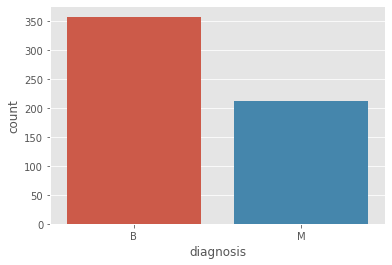

In [238]:
# visualize the distribution of our binary classes

import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('ggplot')

sns.countplot(df.index);plt.show()

Given that there is about twice more data on Benign cells than Malignant, a model will become bias towards classifying Benign cells

# Data Preprocessing



In [239]:
# Separate features (X) from target (y)
import numpy as np

X = df.values
y = (df.index == 'M')
y = y.astype(np.double)

In [240]:
# normalize features
from sklearn.preprocessing import normalize
X = normalize(X, axis = 0)

In [241]:
# parse data to training and testing set for evaluation

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = .20, random_state = 42, shuffle = True)

In [242]:
# Transform data to PyTorch tensors and separate data into batches
from skorch.dataset import Dataset
from torch.utils.data import DataLoader

# Wrap each observation with its corresponding target
train = Dataset(X_train,y_train) 
test = Dataset(X_test,y_test) 

# separate data into batches of 16
train_dl = DataLoader(train, batch_size = 16, pin_memory = True)
test_dl = DataLoader(test, batch_size = 16, pin_memory = True)

Now that we have all the data formatted, let's instatiate our model, criterion, and optimizer

# Instantiate Logistic Regression

In [243]:
# instantiate model and place it on GPU

device = torch.device('cuda')
model = LogisticRegression(30).to(device)
model

LogisticRegression(
  (linear): Linear()
  (sigmoid): Sigmoid()
)

In [244]:
# initiate loss function
criterion = BCELoss()

In [245]:
# initiate optimizer
from torch import optim
optimizer = optim.SGD(model.parameters(), lr = .01)

Make one forward pass to make sure everything works as it should

In [246]:
# test train_dl
batch_X,batch_y = next(iter(train_dl))
print(f"batch_X.shape: {batch_X.shape}")
print('-'*35)
print(f"batch_X.shape: {batch_y.shape}")

batch_X.shape: torch.Size([16, 30])
-----------------------------------
batch_X.shape: torch.Size([16])


In [247]:
# Assert our model makes as many predictions according to the batch
# all inputs must be of type .float()

output = model(batch_X.cuda().float())
output.shape

torch.Size([16])

In [248]:
# average loss
loss = criterion(output,batch_y.cuda().float())
loss

tensor(0.6896, device='cuda:0', grad_fn=<MeanBackward0>)

In [249]:
# compute gradients by calling .backward()
loss.backward()

In [250]:
# take a step
optimizer.step()

# Train Logistic Regression

Now that we have asserted our model works as should, it's time to train it

In [251]:

def train(model, iterator, optimizer, criterion):
    
    # hold avg loss and acc sum of all batches
    epoch_loss = 0
    epoch_acc = 0
    
    
    for batch in iterator:
        
        # zero-out all gradients (if any) from our model parameters
        model.zero_grad()
        
        
        
        # extract input and label
        
        # input.shape = (B, fetures)
        input = batch[0].cuda().float()
        # label.shape = (B)
        label = batch[1].cuda().float()
        
        
        # Start PyTorch's Dynamic Graph
        
        # predictions.shape = (B)
        predictions = model(input)
        
        # average batch loss 
        loss = criterion(predictions, label)
        
        # calculate grad(loss) / grad(parameters)
        # "clears" PyTorch's dynamic graph
        loss.backward()
        
        
        # perform SGD "step" operation
        optimizer.step()
        
        
        # Given that PyTorch variables are "contagious" (they record all operations)
        # we need to ".detach()" to stop them from recording any performance
        # statistics
        
        
        # average batch accuracy
        acc = binary_accuracy(predictions.detach(), label)
        

        
        # record our stats
        epoch_loss += loss.detach()
        epoch_acc += acc
        
    # NOTE: tense.item() unpacks Tensor item to a regular python object 
    # tense.tensor([1]).item() == 1
        
    # return average loss and acc of epoch
    return epoch_loss.item() / len(iterator), epoch_acc / len(iterator)


In [252]:
# compute average accuracy per batch

def binary_accuracy(preds, y):
    # preds.shape = (B)
    # y.shape = (B)

    #round predictions to the closest integer
    rounded_preds = torch.round(preds)
    correct = (rounded_preds == y).sum()
    acc = correct.item() / len(y)
    return acc

In [253]:
import time

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs
    
    

In [254]:
def evaluate(model, iterator, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
        
    # turn off grad tracking as we are only evaluation performance
    with torch.no_grad():
    
        for batch in iterator:

            # extract input and label       
            input = batch[0].cuda().float()
            label = batch[1].cuda().float()


            # predictions.shape = (B,1)
            predictions = model(input)

            # average batch loss 
            loss = criterion(predictions, label)

            # average batch accuracy
            acc = binary_accuracy(predictions, label)

            epoch_loss += loss
            epoch_acc += acc
        
    return epoch_loss.item() / len(iterator), epoch_acc / len(iterator)

In [255]:
N_EPOCHS = 150

# track statistics
track_stats = {'epoch': [],
               'train_loss': [],
              'train_acc': [],
              'valid_loss':[],
              'valid_acc':[]}


best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):

    start_time = time.time()
    
    train_loss, train_acc = train(model, train_dl, optimizer, criterion)
    valid_loss, valid_acc = evaluate(model, test_dl, criterion)
    
    end_time = time.time()
    
    # record operations
    track_stats['epoch'].append(epoch + 1)
    track_stats['train_loss'].append(train_loss)
    track_stats['train_acc'].append(train_acc)
    track_stats['valid_loss'].append(valid_loss)
    track_stats['valid_acc'].append(valid_acc)
    
    

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    # if this was our best performance, record model parameters
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'best_log_regression.pt')
    
    # print out stats
    print('-'*75)
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')


---------------------------------------------------------------------------
Epoch: 01 | Epoch Time: 0m 0s
	Train Loss: 0.662 | Train Acc: 62.65%
	 Val. Loss: 0.653 |  Val. Acc: 63.28%
---------------------------------------------------------------------------
Epoch: 02 | Epoch Time: 0m 0s
	Train Loss: 0.658 | Train Acc: 62.65%
	 Val. Loss: 0.649 |  Val. Acc: 63.28%
---------------------------------------------------------------------------
Epoch: 03 | Epoch Time: 0m 0s
	Train Loss: 0.655 | Train Acc: 62.65%
	 Val. Loss: 0.646 |  Val. Acc: 63.28%
---------------------------------------------------------------------------
Epoch: 04 | Epoch Time: 0m 0s
	Train Loss: 0.652 | Train Acc: 62.65%
	 Val. Loss: 0.643 |  Val. Acc: 63.28%
---------------------------------------------------------------------------
Epoch: 05 | Epoch Time: 0m 0s
	Train Loss: 0.649 | Train Acc: 62.65%
	 Val. Loss: 0.639 |  Val. Acc: 63.28%
---------------------------------------------------------------------------
Epoc

Epoch: 45 | Epoch Time: 0m 0s
	Train Loss: 0.545 | Train Acc: 71.98%
	 Val. Loss: 0.534 |  Val. Acc: 70.31%
---------------------------------------------------------------------------
Epoch: 46 | Epoch Time: 0m 0s
	Train Loss: 0.543 | Train Acc: 72.20%
	 Val. Loss: 0.532 |  Val. Acc: 70.31%
---------------------------------------------------------------------------
Epoch: 47 | Epoch Time: 0m 0s
	Train Loss: 0.541 | Train Acc: 73.06%
	 Val. Loss: 0.530 |  Val. Acc: 71.09%
---------------------------------------------------------------------------
Epoch: 48 | Epoch Time: 0m 0s
	Train Loss: 0.539 | Train Acc: 73.06%
	 Val. Loss: 0.528 |  Val. Acc: 71.09%
---------------------------------------------------------------------------
Epoch: 49 | Epoch Time: 0m 0s
	Train Loss: 0.537 | Train Acc: 73.06%
	 Val. Loss: 0.526 |  Val. Acc: 71.09%
---------------------------------------------------------------------------
Epoch: 50 | Epoch Time: 0m 0s
	Train Loss: 0.535 | Train Acc: 73.49%
	 Val. Loss

	 Val. Loss: 0.459 |  Val. Acc: 78.91%
---------------------------------------------------------------------------
Epoch: 90 | Epoch Time: 0m 0s
	Train Loss: 0.471 | Train Acc: 82.11%
	 Val. Loss: 0.458 |  Val. Acc: 78.91%
---------------------------------------------------------------------------
Epoch: 91 | Epoch Time: 0m 0s
	Train Loss: 0.470 | Train Acc: 82.33%
	 Val. Loss: 0.457 |  Val. Acc: 78.91%
---------------------------------------------------------------------------
Epoch: 92 | Epoch Time: 0m 0s
	Train Loss: 0.468 | Train Acc: 82.76%
	 Val. Loss: 0.455 |  Val. Acc: 78.91%
---------------------------------------------------------------------------
Epoch: 93 | Epoch Time: 0m 0s
	Train Loss: 0.467 | Train Acc: 83.41%
	 Val. Loss: 0.454 |  Val. Acc: 79.69%
---------------------------------------------------------------------------
Epoch: 94 | Epoch Time: 0m 0s
	Train Loss: 0.466 | Train Acc: 83.62%
	 Val. Loss: 0.453 |  Val. Acc: 80.47%
-----------------------------------------

---------------------------------------------------------------------------
Epoch: 134 | Epoch Time: 0m 0s
	Train Loss: 0.423 | Train Acc: 86.85%
	 Val. Loss: 0.407 |  Val. Acc: 90.62%
---------------------------------------------------------------------------
Epoch: 135 | Epoch Time: 0m 0s
	Train Loss: 0.422 | Train Acc: 87.07%
	 Val. Loss: 0.406 |  Val. Acc: 90.62%
---------------------------------------------------------------------------
Epoch: 136 | Epoch Time: 0m 0s
	Train Loss: 0.421 | Train Acc: 87.28%
	 Val. Loss: 0.405 |  Val. Acc: 90.62%
---------------------------------------------------------------------------
Epoch: 137 | Epoch Time: 0m 0s
	Train Loss: 0.420 | Train Acc: 87.28%
	 Val. Loss: 0.404 |  Val. Acc: 90.62%
---------------------------------------------------------------------------
Epoch: 138 | Epoch Time: 0m 0s
	Train Loss: 0.419 | Train Acc: 87.28%
	 Val. Loss: 0.403 |  Val. Acc: 90.62%
---------------------------------------------------------------------------

# Visualization

Our model performed very well! With a top validation accuracy of 90.62%

Now, let us graph our results

In [256]:
# format data 
import pandas as pd

stats = pd.DataFrame(track_stats)
stats

,epoch,train_loss,train_acc,valid_loss,valid_acc
0,1,0.661884,0.626539,0.652851,0.632812
1,2,0.658471,0.626539,0.649458,0.632812
2,3,0.655121,0.626539,0.646100,0.632812
3,4,0.651815,0.626539,0.642780,0.632812
4,5,0.648550,0.626539,0.639496,0.632812
5,6,0.645323,0.626539,0.636249,0.632812
6,7,0.642134,0.628695,0.633039,0.632812
7,8,0.638983,0.628695,0.629865,0.632812
8,9,0.635868,0.628695,0.626728,0.640625
9,10,0.632790,0.628695,0.623626,0.640625


In [257]:
data = []
for row in stats.iterrows():
    data.append(row[1].to_dict())
data

[{'epoch': 1.0,
  'train_loss': 0.6618835843842605,
  'train_acc': 0.6265394088669951,
  'valid_loss': 0.6528506278991699,
  'valid_acc': 0.6328125},
 {'epoch': 2.0,
  'train_loss': 0.6584710745975889,
  'train_acc': 0.6265394088669951,
  'valid_loss': 0.6494578719139099,
  'valid_acc': 0.6328125},
 {'epoch': 3.0,
  'train_loss': 0.6551205207561624,
  'train_acc': 0.6265394088669951,
  'valid_loss': 0.6461004018783569,
  'valid_acc': 0.6328125},
 {'epoch': 4.0,
  'train_loss': 0.6518148882635708,
  'train_acc': 0.6265394088669951,
  'valid_loss': 0.642779529094696,
  'valid_acc': 0.6328125},
 {'epoch': 5.0,
  'train_loss': 0.6485495074041958,
  'train_acc': 0.6265394088669951,
  'valid_loss': 0.6394957304000854,
  'valid_acc': 0.6328125},
 {'epoch': 6.0,
  'train_loss': 0.6453227339119747,
  'train_acc': 0.6265394088669951,
  'valid_loss': 0.6362490057945251,
  'valid_acc': 0.6328125},
 {'epoch': 7.0,
  'train_loss': 0.6421338443098397,
  'train_acc': 0.6286945812807881,
  'valid_loss'

In [258]:
import hiplot as hip
hip.Experiment.from_iterable(data).display(force_full_width = True)

The above graph gives us a very nice way to visualize our expected general patterns: 
as the number of epoch increases, train and validation loss decreases while train and validation accuracy increase

Further, we can investigate the magnitude of each weight parameter to shed insight on the variables that had a higher level of influence on our prediction (assuming that higher magnitudes correlate with higher importance)

**NOTE**: this is only possible as our model is just a one layer linear operation. If this was a "deep" model, interpretation by weight magnitude would not be possible

In [259]:
params = list(model.parameters())[0].detach().cpu().view(-1).numpy()
param_df = pd.DataFrame(params).T
param_df.columns = df.columns
param_df

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,points_mean,symmetry_mean,dimension_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,points_worst,symmetry_worst,dimension_worst
0,1.161765,0.677237,2.255095,3.453925,-0.381582,2.046112,5.107539,3.268645,0.249327,0.61387,...,2.525464,0.678428,-0.570225,5.125237,0.906672,3.380883,1.896072,4.835514,2.884102,2.432787


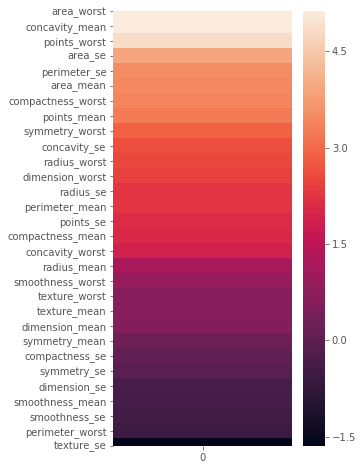

In [260]:
plt.figure(figsize = (4,8))
sns.heatmap(param_df.T.sort_values(0,ascending = False))

Assuming that weights with higher magnitudes equate to a higher level of importance, we can see that 

1. area_worst
2. area_se and
3. points_worst

were the top 3 variables that helped us differentiate between Malign and Benign cells.

# Conclusion

Logistic Regression is a poweful method to analyze the relationship between quantitative and binary qualitative variables that uses the techniques of DL to present a meaninful relationship.

Given its "shallow" architecture in comparison with alternative DL architectures, it does not necessitate much data to learn relationships.

As such, Logistic Regression is an important concept to have on anyone's Data Science arsenal